(18202, 70, 1)


c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1

c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\torch\nn\_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



Epoch: 0
Batch 200, loss = 2577.3159, recon_loss = 2577.0107, kl_loss = 0.3051
Batch 400, loss = 2111.4924, recon_loss = 2110.7324, kl_loss = 0.7600
Batch 600, loss = 1817.1975, recon_loss = 1815.0764, kl_loss = 2.1211
Average loss: 2047.5006
Epoch: 1
Batch 200, loss = 1903.8157, recon_loss = 1902.2787, kl_loss = 1.5370
Batch 400, loss = 1668.7672, recon_loss = 1666.2151, kl_loss = 2.5521
Batch 600, loss = 2042.2843, recon_loss = 2041.1072, kl_loss = 1.1771
Average loss: 1736.3726
Epoch: 2
Batch 200, loss = 1679.5018, recon_loss = 1677.7482, kl_loss = 1.7537
Batch 400, loss = 1591.0553, recon_loss = 1588.7009, kl_loss = 2.3543
Batch 600, loss = 1564.8751, recon_loss = 1562.8037, kl_loss = 2.0714
Average loss: 1781.3686
Epoch: 3
Batch 200, loss = 1931.3826, recon_loss = 1926.9705, kl_loss = 4.4121
Batch 400, loss = 1650.2971, recon_loss = 1645.7551, kl_loss = 4.5420
Batch 600, loss = 1681.8253, recon_loss = 1677.1235, kl_loss = 4.7018
Average loss: 1794.2991
Epoch: 4
Batch 200, loss = 1

tensor(152.8866, device='cuda:0', grad_fn=<MseLossBackward0>)

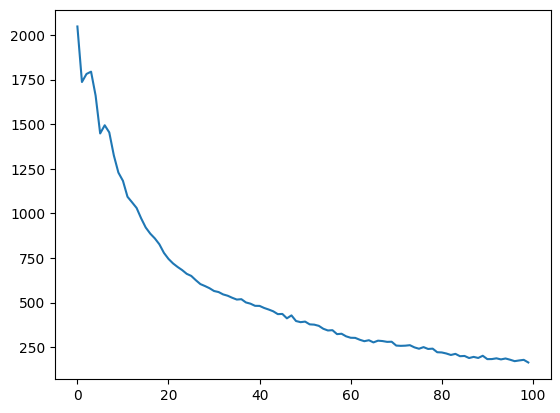

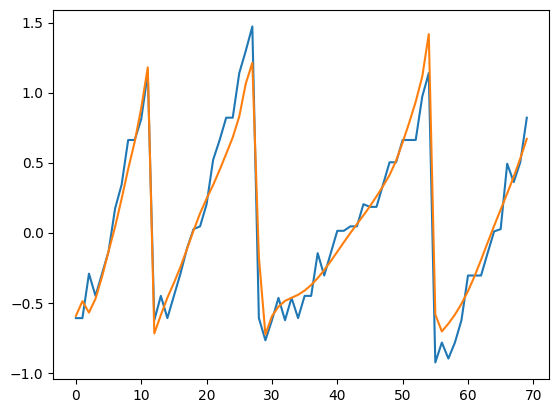

In [3]:
## full import+training code

#%matplotlib widget
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn   
import pandas as pd
import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

df = pd.read_pickle(fr'C:\Users\achfr\OneDrive - University of Edinburgh\Compiled dataset\df_compiled_mothers_labelled_cyclefate.csv')
df_tracks= df.pivot(values=[
    'GrowthRateSize','GrowthRateLength','GrowthRateFeretMax','GrowthRateFeretMaxSliding',
    'InterdivisionTimes','DivisionRate','DivisionRate_filtered','TrackLength','TrackLength_filtered',
    'Size','SizeAtBirthSize','FeretMax','SizeAtBirthFeretMax','MaxLength','SpineLength','SizeAtBirthLength','SpineWidth',
    'MeanIntensity_mch','MeanIntensity_gfp','Maxgfp',
    'BacteriaLineage','NextDivisionFrame','PreviousDivisionFrame',
    'TrackHeadIndices','Prev','Next','Idx','Frame','Indices','PositionIdx','cellcycle_fate'], 
    index=['Position','ParentTrackHeadIndices','Medium','Treatment','RepeatID','RepeatDate','fate','DeathSubtype'],
    columns='Time')

exp_name = 'glu_cip_1'

medium,treatment,replicate = exp_name.split('_')

skip_timepoints = 1
if medium == 'gly': skip_timepoints = 2  #in glycerol data is missing every other timepoint because data was collected every 10 minutes instead of 5 so we need to skip every other timepoint

frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
size_array = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array)
cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])

liste=[]
for i in range(size_array.shape[0]):
    serie =  size_array[i]
    t_death = np.where(cyclefate_array[i,range(0,cyclefate_array.shape[1],skip_timepoints)] != 'alive')[0][0]
    usable_data = serie[24:min(t_death,168)]
    seq_len = 70
    # for i in range(len(usable_data)//seq_len):  #splitting the data into sequences of length seq_len
    #     tre = (i+1)*seq_len
    #     liste.append(usable_data[tre-seq_len:tre])
    for i in range(0,len(usable_data)-seq_len,1):
        liste.append(usable_data[i:i+seq_len])

X_train = np.array(np.random.permutation(liste))[:,:,:]

# X_train, X_test = Data[:int(0.9*Data.shape[0])], Data[int(0.9*Data.shape[0]):]

train_dataset = TensorDataset(torch.from_numpy(X_train))
# test_dataset = TensorDataset(torch.from_numpy(X_test))

sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

print(X_train.shape)

dload = './model_dir_mm' #download directory
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 30
learning_rate = 0.0005
n_epochs = 100
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=200
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

vrae.fit(train_dataset, save=True)
file = open(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\print.txt').readlines()
losses = []
for line in file:
    if 'Average loss' in line:
        losses.append(float(line.split(' ')[-1][:-2]))
plt.plot(losses)
# vrae.load(fr'C:\Users\achfr\timeseries-clustering-vae\it_worked\model_200ep.pth')

vrae.eval()
testseq = train_dataset[30:batch_size+30][0].float()
print(testseq.shape)
# plt.plot(testseq[:,:,0].T)
testseq2 = testseq.permute(1, 0, 2).cuda()
print(testseq2.shape)
outp = vrae.forward(testseq2)
print(outp[0].shape)

k=np.random.randint(0,batch_size)
input_seq = testseq2[:,k,0].cpu().detach().numpy()
output_seq = outp[0][:,k,0].cpu().detach().numpy()
plt.figure()
plt.plot(input_seq.T)
plt.plot(output_seq.T)

loss = nn.MSELoss(reduction='sum')
loss(testseq2, outp[0])

#19min 200ep glu ctrl 2

(48060, 70, 1)
Epoch: 0


c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1

c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\torch\nn\_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



Batch 200, loss = 3851.1311, recon_loss = 3850.2307, kl_loss = 0.9004
Batch 400, loss = 3761.3250, recon_loss = 3759.7578, kl_loss = 1.5672
Batch 600, loss = 3471.2041, recon_loss = 3468.5229, kl_loss = 2.6811
Batch 800, loss = 3303.9397, recon_loss = 3301.5430, kl_loss = 2.3967
Average loss: 3707.8773
Epoch: 1
Batch 200, loss = 3227.6272, recon_loss = 3224.7158, kl_loss = 2.9115
Batch 400, loss = 3045.8462, recon_loss = 3042.1162, kl_loss = 3.7299
Batch 600, loss = 3179.3569, recon_loss = 3175.8521, kl_loss = 3.5050
Batch 800, loss = 3014.4805, recon_loss = 3010.3438, kl_loss = 4.1368
Average loss: 3218.5183
Epoch: 2
Batch 200, loss = 3184.3555, recon_loss = 3180.7305, kl_loss = 3.6251
Batch 400, loss = 3210.2371, recon_loss = 3206.3003, kl_loss = 3.9368
Batch 600, loss = 3182.4773, recon_loss = 3178.9131, kl_loss = 3.5643
Batch 800, loss = 3031.9924, recon_loss = 3028.1558, kl_loss = 3.8367
Average loss: 3157.8190
Epoch: 3
Batch 200, loss = 3106.4075, recon_loss = 3102.6084, kl_loss 

tensor(1002.1324, device='cuda:0', grad_fn=<MseLossBackward0>)

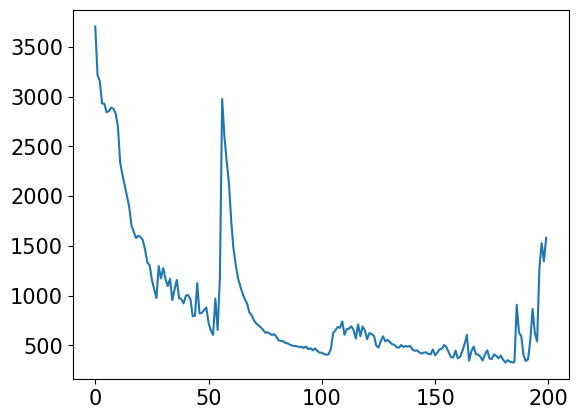

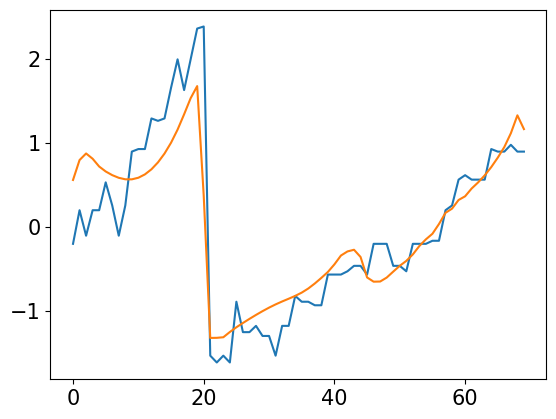

In [74]:
## full import+training code cip  tet crtl

#%matplotlib widget
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn   
import pandas as pd
import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

df = pd.read_pickle(fr'C:\Users\achfr\OneDrive - University of Edinburgh\Compiled dataset\df_compiled_mothers_labelled_cyclefate.csv')
df_tracks= df.pivot(values=[
    'GrowthRateSize','GrowthRateLength','GrowthRateFeretMax','GrowthRateFeretMaxSliding',
    'InterdivisionTimes','DivisionRate','DivisionRate_filtered','TrackLength','TrackLength_filtered',
    'Size','SizeAtBirthSize','FeretMax','SizeAtBirthFeretMax','MaxLength','SpineLength','SizeAtBirthLength','SpineWidth',
    'MeanIntensity_mch','MeanIntensity_gfp','Maxgfp',
    'BacteriaLineage','NextDivisionFrame','PreviousDivisionFrame',
    'TrackHeadIndices','Prev','Next','Idx','Frame','Indices','PositionIdx','cellcycle_fate'], 
    index=['Position','ParentTrackHeadIndices','Medium','Treatment','RepeatID','RepeatDate','fate','DeathSubtype'],
    columns='Time')

exp_name = 'glu_cip_1'

medium,treatment,replicate = exp_name.split('_')

skip_timepoints = 1
if medium == 'gly': skip_timepoints = 2  #in glycerol data is missing every other timepoint because data was collected every 10 minutes instead of 5 so we need to skip every other timepoint

frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
size_array = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
# size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array)
cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])

liste=[]
for i in range(size_array.shape[0]):
    serie =  size_array[i]
    t_death = np.where(cyclefate_array[i,range(0,cyclefate_array.shape[1],skip_timepoints)] != 'alive')[0][0]
    usable_data = serie[24:min(t_death,168)]
    seq_len = 70
    # for i in range(len(usable_data)//seq_len):  #splitting the data into sequences of length seq_len
    #     tre = (i+1)*seq_len
    #     liste.append(usable_data[tre-seq_len:tre])
    for i in range(0,len(usable_data)-seq_len,1):
        liste.append(usable_data[i:i+seq_len])


exp_name = 'glu_tet_1'
medium,treatment,replicate = exp_name.split('_')
skip_timepoints = 1
if medium == 'gly': skip_timepoints = 2  #in glycerol data is missing every other timepoint because data was collected every 10 minutes instead of 5 so we need to skip every other timepoint
frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
size_array = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
# size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array)
cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])
for i in range(size_array.shape[0]):
    serie =  size_array[i]
    t_death = np.where(cyclefate_array[i,range(0,cyclefate_array.shape[1],skip_timepoints)] != 'alive')[0][0]
    usable_data = serie[24:min(t_death,168)]
    seq_len = 70
    # for i in range(len(usable_data)//seq_len):  #splitting the data into sequences of length seq_len
    #     tre = (i+1)*seq_len
    #     liste.append(usable_data[tre-seq_len:tre])
    for i in range(0,len(usable_data)-seq_len,1):
        liste.append(usable_data[i:i+seq_len])

exp_name = 'glu_control_1'
medium,treatment,replicate = exp_name.split('_')
skip_timepoints = 1
if medium == 'gly': skip_timepoints = 2  #in glycerol data is missing every other timepoint because data was collected every 10 minutes instead of 5 so we need to skip every other timepoint
frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
size_array = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
# size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array)
cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])
for i in range(size_array.shape[0]):
    serie =  size_array[i]
    t_death = np.where(cyclefate_array[i,range(0,cyclefate_array.shape[1],skip_timepoints)] != 'alive')[0][0]
    usable_data = serie[24:min(t_death,168)]
    seq_len = 70
    # for i in range(len(usable_data)//seq_len):  #splitting the data into sequences of length seq_len
    #     tre = (i+1)*seq_len
    #     liste.append(usable_data[tre-seq_len:tre])
    for i in range(0,len(usable_data)-seq_len,1):
        liste.append(usable_data[i:i+seq_len])

liste = TimeSeriesScalerMeanVariance().fit_transform(np.array(liste))
X_train = np.array(np.random.permutation(liste))[:,:,:]


# X_train, X_test = Data[:int(0.9*Data.shape[0])], Data[int(0.9*Data.shape[0]):]

train_dataset = TensorDataset(torch.from_numpy(X_train))
# test_dataset = TensorDataset(torch.from_numpy(X_test))

sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

print(X_train.shape)

dload = './model_dir_mm' #download directory
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 60
learning_rate = 0.0005
n_epochs = 200
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=200
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

vrae.fit(train_dataset, save=True)
file = open(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\print.txt').readlines()
losses = []
for line in file:
    if 'Average loss' in line:
        losses.append(float(line.split(' ')[-1][:-2]))
plt.plot(losses)
# vrae.load(fr'C:\Users\achfr\timeseries-clustering-vae\it_worked\model_200ep.pth')

vrae.eval()
testseq = train_dataset[30:batch_size+30][0].float()
print(testseq.shape)
# plt.plot(testseq[:,:,0].T)
testseq2 = testseq.permute(1, 0, 2).cuda()
print(testseq2.shape)
outp = vrae.forward(testseq2)
print(outp[0].shape)

k=np.random.randint(0,batch_size)
input_seq = testseq2[:,k,0].cpu().detach().numpy()
output_seq = outp[0][:,k,0].cpu().detach().numpy()
plt.figure()
plt.plot(input_seq.T)
plt.plot(output_seq.T)

loss = nn.MSELoss(reduction='sum')
loss(testseq2, outp[0])

#19min 200ep glu ctrl 2

31858 9


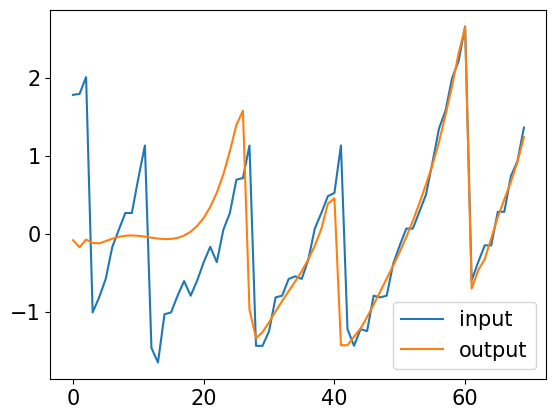

In [92]:
# plot recon expample epoch loss
vrae.eval()
k1=np.random.randint(0,len(X_train)-batch_size)
testseq = torch.from_numpy(X_train[k1:k1+batch_size]).float()

# print(testseq.shape)
testseq2 = testseq.permute(1, 0, 2).cuda()
# print(testseq2.shape)
outp = vrae.forward(testseq2)
# print(outp[0].shape)

k=np.random.randint(0,batch_size)
input_seq = testseq2[:,k,0].cpu().detach().numpy()
output_seq = outp[0][:,k,0].cpu().detach().numpy()
plt.figure()
plt.plot(input_seq.T)
plt.plot(output_seq.T)
import torch.nn as nn   
loss = nn.MSELoss(reduction='sum')
loss(testseq2, outp[0])
plt.legend(['input', 'output'])
plt.rcParams.update({'font.size': 15})
print(k1,k)

# # plot epoch loss
# file = open(fr'C:\Users\achfr\timeseries-clustering-vae\model_dir_mm\print.txt').readlines()
# losses = []
# for line in file:
#     if 'Average loss' in line:
#         losses.append(float(line.split(' ')[-1][:-2]))
# plt.plot(losses)

In [93]:
# create dataset with all size trajectories of living cells

# dataset_name_list = ['gly_control_1', 'gly_control_2', 'gly_control_3', 'gly_cip_1', 'gly_cip_2', 'gly_tet_1', 'gly_tet_2', 'gly_tet_3', 'gly_ciptet_1', 'gly_ciptet_2', 'glu_control_1', 'glu_control_2', 'glu_cip_1', 'glu_cip_2', 
#  'glu_tet_1', 'glu_tet_2', 'glu_ciptet_1', 'glu_ciptet_2', 'gluaa_control_1', 'gluaa_control_2', 'gluaa_cip_1', 'gluaa_cip_2', 'gluaa_cip_3', 'gluaa_tet_1', 'gluaa_tet_2', 'gluaa_ciptet_1', 'gluaa_ciptet_2']
# dataset_lengths = [188,376,304,252,307,317,277,411,328,431, 78,342,386,377,351,354,355,350,283,334,218,191,235,327,237,343,304]

# gigadataset_X = []
# gigadataset_Y = []
# giga_other_stuff = []

# for_heatmap = []
# for_heatmap_unscaled = []

# for exp_name in dataset_name_list:
#     print(exp_name)
#     medium,treatment,replicate = exp_name.split('_')

#     skip_timepoints = 1
#     if medium == 'gly': skip_timepoints = 2  #in glycerol data is missing every other timepoint because data was collected every 10 minutes instead of 5 so we need to skip every other timepoint

#     frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
#     size_array_unscaled = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
#     size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array_unscaled)
#     elongation_rate_array = np.array([list(frame['GrowthRateFeretMax'].T[k]) for k in frame['GrowthRateFeretMax'].T.keys()])
#     gfp_array = np.array([list(frame['MeanIntensity_gfp'].T[k]) for k in frame['MeanIntensity_gfp'].T.keys()])
#     mch_array = np.array([list(frame['MeanIntensity_mch'].T[k]) for k in frame['MeanIntensity_mch'].T.keys()])
#     cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])
#     fates = np.array([i for i in frame.reset_index('fate')['fate']])
#     death_subtypes = np.array([i for i in frame.reset_index('DeathSubtype')['DeathSubtype']])

#     for i in range(size_array.shape[0]):
#             for_heatmap.append(size_array[i])
#             for_heatmap_unscaled.append(size_array_unscaled[i])
#             serie =  size_array[i,[cyclefate_array[i,k]=='alive' for k in range(0,size_array.shape[1])]]
#             # t_death = np.where(cyclefate_array[i,range(0,cyclefate_array.shape[1],skip_timepoints)] != 'alive')[0][0]
#             cropped_serie = serie[24//skip_timepoints:min((72+24)//skip_timepoints,len(serie))] # uses first 6 hours or until death
#             if len(cropped_serie) >0:
#                 gigadataset_X.append(torch.from_numpy(cropped_serie))
#                 gigadataset_Y.append((medium,treatment,replicate,fates[i],death_subtypes[i],len(cropped_serie)))
#                 dict_other_stuff = {'elongation_rate':torch.from_numpy(elongation_rate_array[i]),'cyclefate':cyclefate_array[i],'gfp':torch.from_numpy(gfp_array[i]),'mch':torch.from_numpy(mch_array[i])}
#                 giga_other_stuff.append(dict_other_stuff)

# from torch.nn.utils.rnn import pack_padded_sequence
# from torch.utils.data import Dataset

# class PackedSequenceDataset(Dataset):
#     def __init__(self, data):
#         self.data = data
#         self.lengths = [len(seq) for seq in data]

#     def __getitem__(self, index):
#         sequence = self.data[index]
#         length = self.lengths[index]
#         packed_sequence = pack_padded_sequence(sequence.unsqueeze(0), [length], batch_first=True, enforce_sorted=False)
#         return packed_sequence.data, length

#     def __len__(self):
#         return len(self.data)

# # Create the dataset
# dataset = PackedSequenceDataset(gigadataset_X)

# label_map = {
#     ('gly', 'control'): 0,
#     ('gly', 'cip'): 1,
#     ('gly', 'tet'): 2,
#     ('gly', 'ciptet'): 3,
#     ('glu', 'control'): 4,
#     ('glu', 'cip'): 5,
#     ('glu', 'tet'): 6,
#     ('glu', 'ciptet'): 7,
#     ('gluaa', 'control'): 8,
#     ('gluaa', 'cip'): 9,
#     ('gluaa', 'tet'): 10,
#     ('gluaa', 'ciptet'): 11
# }

# labels = [label_map[k[:2]] for k in gigadataset_Y]

# 1min - 1min30


dataset_name_list = ['glu_control_2', 'glu_cip_2', 'glu_tet_2', 'glu_ciptet_1', 'glu_ciptet_2']
dataset_lengths = [342,377,354,355,350]

gigadataset_X = []
gigadataset_Y = []
giga_other_stuff = []

for_heatmap = []
for_heatmap_unscaled = []

for exp_name in dataset_name_list:
    print(exp_name)
    medium,treatment,replicate = exp_name.split('_')

    skip_timepoints = 1
    if medium == 'gly': skip_timepoints = 2  #in glycerol data is missing every other timepoint because data was collected every 10 minutes instead of 5 so we need to skip every other timepoint

    frame = df_tracks.loc(axis=0)[:,:,medium,treatment,replicate]
    size_array_unscaled = np.array([list(frame['FeretMax'].T[k]) for k in frame['FeretMax'].T.keys()])
    size_array = TimeSeriesScalerMeanVariance().fit_transform(size_array_unscaled)
    elongation_rate_array = np.array([list(frame['GrowthRateFeretMax'].T[k]) for k in frame['GrowthRateFeretMax'].T.keys()])
    gfp_array = np.array([list(frame['MeanIntensity_gfp'].T[k]) for k in frame['MeanIntensity_gfp'].T.keys()])
    mch_array = np.array([list(frame['MeanIntensity_mch'].T[k]) for k in frame['MeanIntensity_mch'].T.keys()])
    cyclefate_array = np.array([list(frame['cellcycle_fate'].T[k]) for k in frame['cellcycle_fate'].T.keys()])
    fates = np.array([i for i in frame.reset_index('fate')['fate']])
    death_subtypes = np.array([i for i in frame.reset_index('DeathSubtype')['DeathSubtype']])

    for i in range(size_array.shape[0]):
            for_heatmap.append(size_array[i])
            for_heatmap_unscaled.append(size_array_unscaled[i])
            serie =  size_array[i,[cyclefate_array[i,k]=='alive' for k in range(0,size_array.shape[1])]]
            # t_death = np.where(cyclefate_array[i,range(0,cyclefate_array.shape[1],skip_timepoints)] != 'alive')[0][0]
            cropped_serie = serie[24//skip_timepoints:min((72+24)//skip_timepoints,len(serie))] # uses first 6 hours or until death
            if len(cropped_serie) >0:
                gigadataset_X.append(torch.from_numpy(cropped_serie))
                gigadataset_Y.append((medium,treatment,replicate,fates[i],death_subtypes[i],len(cropped_serie)))
                dict_other_stuff = {'elongation_rate':torch.from_numpy(elongation_rate_array[i]),'cyclefate':cyclefate_array[i],'gfp':torch.from_numpy(gfp_array[i]),'mch':torch.from_numpy(mch_array[i])}
                giga_other_stuff.append(dict_other_stuff)

from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset

class PackedSequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.lengths = [len(seq) for seq in data]

    def __getitem__(self, index):
        sequence = self.data[index]
        length = self.lengths[index]
        packed_sequence = pack_padded_sequence(sequence.unsqueeze(0), [length], batch_first=True, enforce_sorted=False)
        return packed_sequence.data, length

    def __len__(self):
        return len(self.data)

# Create the dataset
dataset = PackedSequenceDataset(gigadataset_X)

label_map = {
    ('gly', 'control'): 0,
    ('gly', 'cip'): 1,
    ('gly', 'tet'): 2,
    ('gly', 'ciptet'): 3,
    ('glu', 'control'): 4,
    ('glu', 'cip'): 5,
    ('glu', 'tet'): 6,
    ('glu', 'ciptet'): 7,
    ('gluaa', 'control'): 8,
    ('gluaa', 'cip'): 9,
    ('gluaa', 'tet'): 10,
    ('gluaa', 'ciptet'): 11
}

labels = [label_map[k[:2]] for k in gigadataset_Y]


glu_control_2
glu_cip_2
glu_tet_2
glu_ciptet_1
glu_ciptet_2


In [94]:
# encodes all the data
vrae.batch_size = 1
projected_comme_jamaid = vrae.transform(dataset)
# vrae.batch_size = 30
# decoded = vrae.reconstruct(TensorDataset(torch.from_numpy((projected_comme_jamaid)).unsqueeze(-1)))

# plot_clustering(projected_comme_jamaid, labels, engine='matplotlib', download = False) # function from paper

In [ ]:
### heatmap code
list_heat = for_heatmap

arr = np.zeros((len(list_heat),300))

for i in range(len(list_heat)):
    serie = list_heat[i]
    for k in range(1,len(serie)-1):
        if np.isnan(serie[k]):
            serie[k] = (serie[k-1]+serie[k+1])/2
    arr[i,:min(len(serie),300)] = serie[:300,0]

dataset_name_list = ['gly_control_1', 'gly_control_2', 'gly_control_3', 'gly_cip_1', 'gly_cip_2', 'gly_tet_1', 'gly_tet_2', 'gly_tet_3', 'gly_ciptet_1', 'gly_ciptet_2', 'glu_control_1', 'glu_control_2', 'glu_cip_1', 'glu_cip_2', 
 'glu_tet_1', 'glu_tet_2', 'glu_ciptet_1', 'glu_ciptet_2', 'gluaa_control_1', 'gluaa_control_2', 'gluaa_cip_1', 'gluaa_cip_2', 'gluaa_cip_3', 'gluaa_tet_1', 'gluaa_tet_2', 'gluaa_ciptet_1', 'gluaa_ciptet_2']
dataset_lengths = [188,376,304,252,307,317,277,411,328,431, 78,342,386,377,351,354,355,350,283,334,218,191,235,327,237,343,304]
import seaborn as sns
fig,ax = plt.subplots(figsize=(50,10))
sns.heatmap(arr[:,:].T, ax=ax, cmap='cubehelix', xticklabels=[], yticklabels=[], vmin=-2.5, vmax=2.5)
ax.axhline(y=24, color='black', linestyle='--')
ax.axhline(y=168, color='black', linestyle='--')

Text(0.5, 1.0, 'PCA on z_run gluaa')

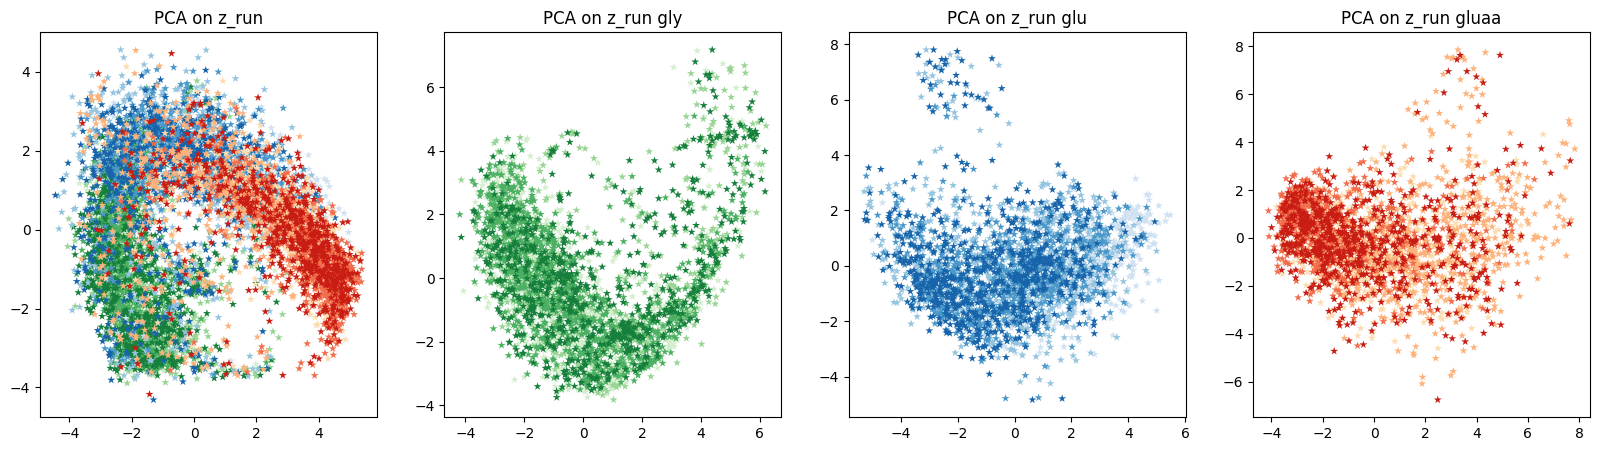

In [4]:
# PCA (and tsne)
from sklearn.decomposition import TruncatedSVD,PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scale_center_before = True

fig,ax = plt.subplots(1,4,figsize=(20,5))

# Create color palettes
green_palette = sns.color_palette("Greens", 4)
blue_palette = sns.color_palette("Blues", 4)
orange_red_palette = sns.color_palette("OrRd", 4)
bourpalette = green_palette + blue_palette + orange_red_palette


# whole data pca
if scale_center_before: z_run = scaler.fit_transform(projected_comme_jamaid)
else: z_run = projected_comme_jamaid
z_run_pca_fit = TruncatedSVD(n_components=20).fit(z_run)
z_run_pca = z_run_pca_fit.transform(z_run)
hex_colors =  bourpalette
colors = [hex_colors[int(i)] for i in labels]
label_names = ['gly_control', 'gly_cip', 'gly_tet', 'gly_ciptet', 'glu_control', 'glu_cip', 'glu_tet', 'glu_ciptet', 'gluaa_control', 'gluaa_cip', 'gluaa_tet', 'gluaa_ciptet']
ax[0].scatter(z_run_pca[:, 0], z_run_pca[:, 1], c=colors, marker='*', linewidths=0)
ax[0].set_title('PCA on z_run')

# # only gly pca
if scale_center_before:z_run_gly = scaler.fit_transform(projected_comme_jamaid[[k[0] == 'gly' for k in gigadataset_Y],:])
else: z_run_gly = projected_comme_jamaid[[k[0] == 'gly' for k in gigadataset_Y],:]
z_run_gly_pca_fit = TruncatedSVD(n_components=20).fit(z_run_gly)
z_run_gly_pca = z_run_gly_pca_fit.transform(z_run_gly)
hex_colors =  green_palette
colors = [hex_colors[int(i)] for i in labels if i in [0,1,2,3]]
label_names = ['gly_control', 'gly_cip', 'gly_tet', 'gly_ciptet']
ax[1].scatter(z_run_gly_pca[:, 0], z_run_gly_pca[:, 1], c=colors, marker='*', linewidths=0)
ax[1].set_title('PCA on z_run gly')

# only glu pca
if scale_center_before:z_run_glu = scaler.fit_transform(projected_comme_jamaid[[k[0] == 'glu' for k in gigadataset_Y],:])
else: z_run_glu = projected_comme_jamaid[[k[0] == 'glu' for k in gigadataset_Y],:]
z_run_glu_pca_fit = TruncatedSVD(n_components=20).fit(z_run_glu)
z_run_glu_pca = z_run_glu_pca_fit.transform(z_run_glu)
hex_colors =  blue_palette
colors = [hex_colors[int(i-4)] for i in labels if i in [4,5,6,7]]
label_names = ['glu_control', 'glu_cip', 'glu_tet', 'glu_ciptet']
ax[2].scatter(z_run_glu_pca[:, 0], z_run_glu_pca[:, 1], c=colors, marker='*', linewidths=0)
ax[2].set_title('PCA on z_run glu')

# only gluaa pca
if scale_center_before:z_run_gluaa = scaler.fit_transform(projected_comme_jamaid[[k[0] == 'gluaa' for k in gigadataset_Y],:])
else: z_run_gluaa = projected_comme_jamaid[[k[0] == 'gluaa' for k in gigadataset_Y],:]
z_run_gluaa_pca_fit = TruncatedSVD(n_components=20).fit(z_run_gluaa)
z_run_gluaa_pca = z_run_gluaa_pca_fit.transform(z_run_gluaa)
hex_colors =  orange_red_palette
colors = [hex_colors[int(i-8)] for i in labels if i in [8,9,10,11]]
label_names = ['gluaa_control', 'gluaa_cip', 'gluaa_tet', 'gluaa_ciptet']
ax[3].scatter(z_run_gluaa_pca[:, 0], z_run_gluaa_pca[:, 1], c=colors, marker='*', linewidths=0)
ax[3].set_title('PCA on z_run gluaa')

# from sklearn.manifold import TSNE
# z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run)
# plt.scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=colors, marker='*', linewidths=0)
# plt.title('tSNE on z_run')
# plt.show()

In [ ]:
# t-SNE all dataset widget

import matplotlib.pyplot as plt
from ipywidgets import interact, Checkbox, HBox, VBox, interactive_output

# Create a dictionary of checkboxes, one for each label
checkboxes = {label: Checkbox(value=True, description=label) for label in label_names}

from ipywidgets import Button

# Create buttons to check and uncheck all checkboxes
check_all_button = Button(description="Check all")
uncheck_all_button = Button(description="Uncheck all")

# Define the button click events
def check_all(b):
    for checkbox in checkboxes.values():
        checkbox.value = True

def uncheck_all(b):
    for checkbox in checkboxes.values():
        checkbox.value = False

# Attach the events to the buttons
check_all_button.on_click(check_all)
uncheck_all_button.on_click(uncheck_all)

# Create a grid of checkboxes with the buttons
checkboxes_grid = VBox([HBox(list(checkboxes.values())[i:i+4]) for i in range(0, len(checkboxes), 4)] + 
                       [HBox([check_all_button, uncheck_all_button])])


def plot(**checkbox_values):
    plt.figure(figsize=(10, 10))
    # For each label, if the checkbox is checked, plot the points with that label
    for label, checked in checkbox_values.items():
        if checked:
            # Get the index of the label
            label_index = label_names.index(label)
            # Get the points with this label
            points = z_run_tsne[[k==label_index for k in labels],:]
            # Plot the points
            plt.scatter(points[:, 0], points[:, 1], c=np.array([hex_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('tSNE on z_run')
    plt.ylim(-75,75)
    plt.xlim(-75,85)
    plt.xlabel('tSNE 1')
    plt.ylabel('tSNE 2')
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed
    plt.show()

# Create interactive output
out = interactive_output(plot, checkboxes)

# Display the checkboxes and the output
display(checkboxes_grid, out)

In [ ]:
# survived/died plots

label_map = {
    ('survived'): 0,
    ('died'): 1,
    ('hyperfila'): 1,
    ('persister'): 0
}

labels_death = [label_map[k[3]] for k in gigadataset_Y]
label_names = ['survived', 'died']
death_colors = ['blue','red']
plot_type = 'pca'

plt.figure(figsize=(10, 10))
for label in label_names:
    print(label)
    # Get the index of the label
    label_index = label_names.index(label)
    # Get the points with this label
    if plot_type == 'pca':
        points = z_run_pca[[k==label_index for k in labels_death],:]
    else:
        points = z_run_tsne[[k==label_index for k in labels_death],:]
    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], c=np.array([death_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('tSNE on z_run')
    if plot_type == 'tsne':
        plt.ylim(-75,75)
        plt.xlim(-75,85)
        plt.xlabel('tSNE 1')
        plt.ylabel('tSNE 2')
    else:
        plt.ylim(-2,5)
        plt.xlim(-5,5)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed

In [ ]:
### 3d
rate_means = []
for i in range(len(giga_other_stuff)):
    rate_means.append(np.mean(giga_other_stuff[i]['elongation_rate'][giga_other_stuff[i]['cyclefate']=='alive'][-20:].numpy()))


import matplotlib.cm as cm
import matplotlib.colors as colors


# Normalize rate_means to range [0, 1]
# norm = colors.Normalize(vmin=min(rate_means), vmax=max(rate_means))
norm = colors.Normalize(vmin=0.1, vmax=1.5)

# Create a colormap
colormap = cm.get_cmap('jet')

# Create a list of colors
color_list = [colormap(norm(value)) for value in rate_means]

fig = plt.figure(figsize=(10, 10))
# plt.scatter(z_run_pca[:, 0], z_run_pca[:, 1], c=color_list, marker='*', linewidths=0)
ax = fig.add_subplot(projection='3d')
ax.scatter(z_run_pca[:, 0], z_run_pca[:, 1], z_run_pca[:, 2], c=color_list, marker='*', linewidths=0)




plt.title('PCA on z_run')
# plt.colorbar(label='Rate Means')
plt.ylim(-2,5)
plt.xlim(-5,5)
plt.show()

c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



control
cip
tet
ciptet
control
cip
tet
ciptet


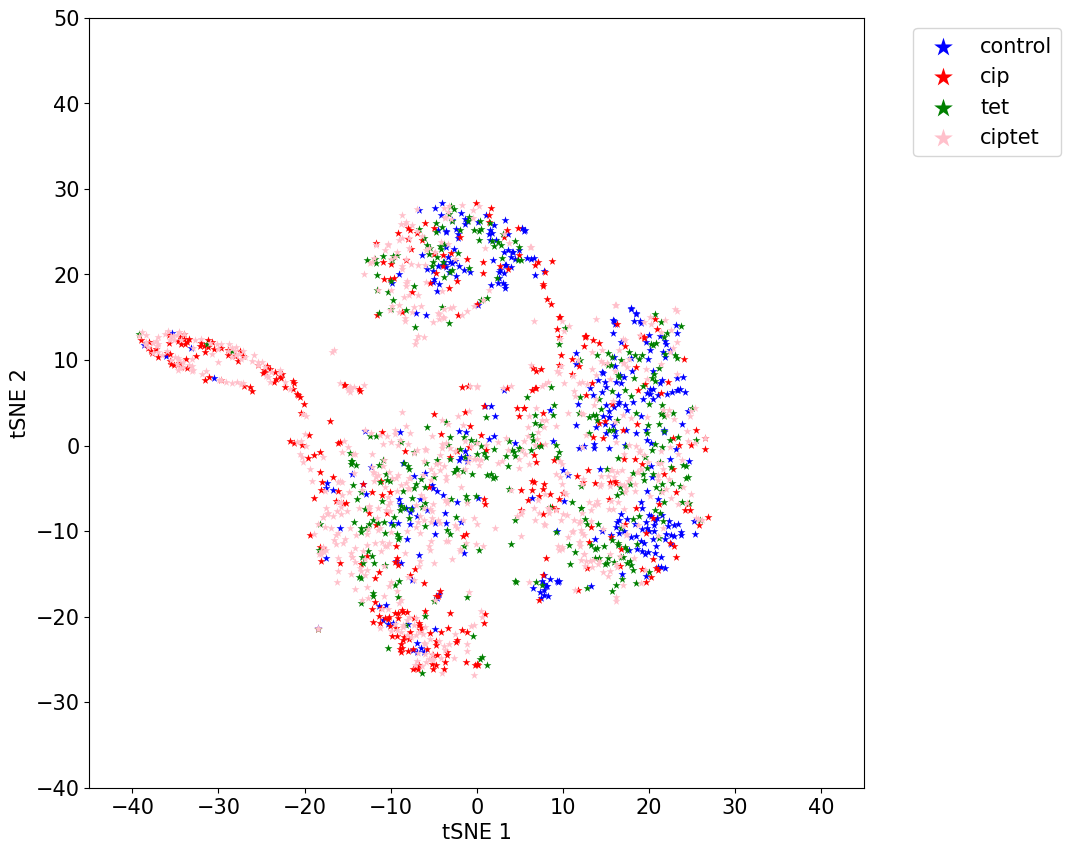

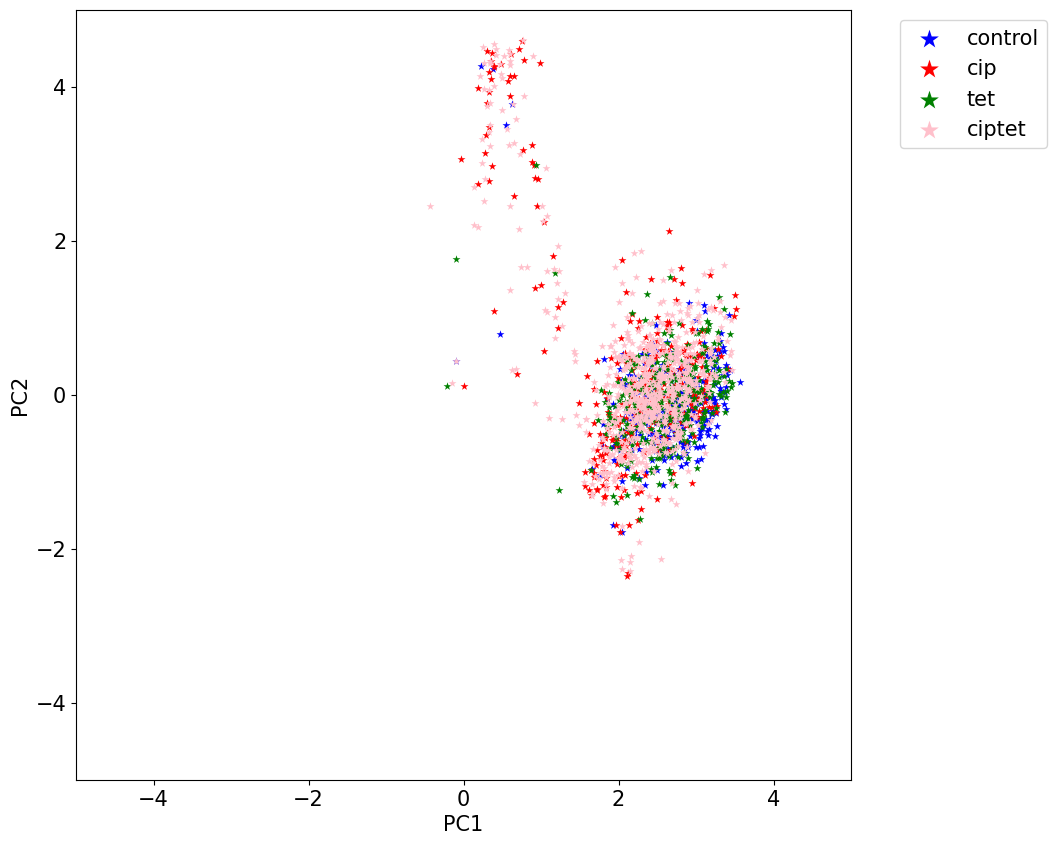

In [96]:
# only glu plot
z_run = projected_comme_jamaid

only_glu_z = z_run[[k[0]=='glu' for k in gigadataset_Y],:]
only_glu_y = [k for k in gigadataset_Y if k[0]=='glu']

only_glu_pca = TruncatedSVD(n_components=3).fit_transform(only_glu_z)
only_glu_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(only_glu_z)

label_map = {
    ('control'): 0,
    ('cip'): 1,
    ('tet'): 2,
    ('ciptet'): 3}

labels_glu = [label_map[k[1]] for k in only_glu_y]

label_names = ['control', 'cip', 'tet', 'ciptet']

# survived/died plots
import matplotlib.pyplot as plt

glu_colors = ['blue','red','green','pink']

plot_type = 'tsne'

plt.figure(figsize=(10, 10))
for label in label_names:
    print(label)
    # Get the index of the label
    label_index = label_names.index(label)
    # Get the points with this label
    if plot_type == 'pca':
        points = only_glu_pca[[k==label_index for k in labels_glu],:]
    else:
        points = only_glu_tsne[[k==label_index for k in labels_glu],:]
    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], c=np.array([glu_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('tSNE on z_run')
    if plot_type == 'tsne':
        plt.ylim(-40,50)
        plt.xlim(-45,45)
        plt.xlabel('tSNE 1')
        plt.ylabel('tSNE 2')
    else:
        plt.ylim(-5,5)
        plt.xlim(-5,5)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed

plot_type = 'pca'

plt.figure(figsize=(10, 10))
for label in label_names:
    print(label)
    # Get the index of the label
    label_index = label_names.index(label)
    # Get the points with this label
    if plot_type == 'pca':
        points = only_glu_pca[[k==label_index for k in labels_glu],:]
    else:
        points = only_glu_tsne[[k==label_index for k in labels_glu],:]
    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], c=np.array([glu_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('tSNE on z_run')
    if plot_type == 'tsne':
        plt.ylim(-40,50)
        plt.xlim(-45,45)
        plt.xlabel('tSNE 1')
        plt.ylabel('tSNE 2')
    else:
        plt.ylim(-5,5)
        plt.xlim(-5,5)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed

In [ ]:
# PCA all dataset widget
import matplotlib.pyplot as plt
from ipywidgets import interact, Checkbox, HBox, VBox, interactive_output

# Create a dictionary of checkboxes, one for each label
checkboxes = {label: Checkbox(value=True, description=label) for label in label_names}

from ipywidgets import Button

# Create buttons to check and uncheck all checkboxes
check_all_button = Button(description="Check all")
uncheck_all_button = Button(description="Uncheck all")

# Define the button click events
def check_all(b):
    for checkbox in checkboxes.values():
        checkbox.value = True

def uncheck_all(b):
    for checkbox in checkboxes.values():
        checkbox.value = False

# Attach the events to the buttons
check_all_button.on_click(check_all)
uncheck_all_button.on_click(uncheck_all)

# Create a grid of checkboxes with the buttons
checkboxes_grid = VBox([HBox(list(checkboxes.values())[i:i+4]) for i in range(0, len(checkboxes), 4)] + 
                       [HBox([check_all_button, uncheck_all_button])])


def plot(**checkbox_values):
    plt.figure(figsize=(10, 10))
    # For each label, if the checkbox is checked, plot the points with that label
    for label, checked in checkbox_values.items():
        if checked:
            # Get the index of the label
            label_index = label_names.index(label)
            # Get the points with this label
            points = z_run_pca[[k==label_index for k in labels],:]
            # Plot the points
            plt.scatter(points[:, 0], points[:, 1], c=np.array([hex_colors[label_index]]), marker='*', linewidths=0, label=label)

    # plt.title('PCA on z_run')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.ylim(-5,5)
    plt.xlim(-5,7)
    # Add a legend outside the plot box
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Increase the size of the symbols in the legend
    for handle in legend.legend_handles:
        handle._sizes = [200]  # adjust as needed
    plt.show()

# Create interactive output
out = interactive_output(plot, checkboxes)

# Display the checkboxes and the output
display(checkboxes_grid, out)


In [ ]:
# scree plots
pca_object,title = z_run_pca_fit,'All Data'
pca_object,title = z_run_gly_pca_fit,'Glycerol Data'
pca_object,title = z_run_glu_pca_fit,'Glucose Data'
pca_object,title = z_run_gluaa_pca_fit,'Glucose+AA Data'

singular_values = pca_object.explained_variance_
explained_variance_ratio = pca_object.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a bar plot of the singular values
color = 'tab:blue'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance', color=color)
ax1.bar(range(1, len(singular_values)+1), singular_values, alpha=0.5, align='center', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a line plot of the cumulative explained variance
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Cumulative Explained Variance', color=color)  # we already handled the x-label with ax1
ax2.step(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, where='mid', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Explained Variance by Principal Components, {title}')
plt.xticks(range(1, len(singular_values)+1))
plt.savefig(fr'C:\Users\achfr\phd\image dump.npy\truc.png')

In [ ]:
#clustering all data 3 clusters
from sklearn.cluster import KMeans, DBSCAN
import sklearn.metrics

label_map_growth_contitions = {'gly':0, 'glu':1, 'gluaa':2}
label_conditions = np.array([label_map_growth_contitions[k[0]] for k in gigadataset_Y])
# label_map_antibiotics = {'control':0, 'cip':1, 'tet':2, 'ciptet':3}
# label_antibiotics = np.array([label_map_antibiotics[k[1]] for k in gigadataset_Y])
# label_all = np.array([label_map[k[:2]] for k in gigadataset_Y])


km_clustering = KMeans(n_clusters=3, n_init = 100).fit(projected_comme_jamaid)
km_labels = km_clustering.labels_


print(np.unique(km_labels, return_counts=True))
print(np.unique(label_conditions, return_counts=True))
print(sklearn.metrics.rand_score(label_conditions, km_labels))
print(sklearn.metrics.adjusted_rand_score(label_conditions, km_labels))

# j1,j2=0,19

# plt.figure()
# for i in range(3):
#     plt.scatter(projected_comme_jamaid[label_conditions==i,j1], projected_comme_jamaid[label_conditions==i,j2], marker='*', linewidths=0, label = ['glycerol', 'glucose', 'glucose+aa'][i])
# plt.xlabel(f'Latent dimension {j1}')
# plt.ylabel(f'Latent dimension {j2}')
# plt.legend()

# plt.figure()
# for i in range(3):
#     plt.scatter(projected_comme_jamaid[km_clustering.labels_==i,j1], projected_comme_jamaid[km_clustering.labels_==i,j2], marker='*', linewidths=0, label = f'cluster #{i}')
# plt.xlabel(f'Latent dimension {j1}')
# plt.ylabel(f'Latent dimension {j2}')
# plt.legend()

# confusion_matrix = sklearn.metrics.confusion_matrix(label_conditions, km_labels)
# plt.figure(figsize=(10, 10))
# sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=False, yticklabels=False, cbar=False)
# plt.savefig(fr'C:\Users\achfr\phd\image dump.npy\truc.png')


#clustering results taking only survivors
label_conditions_survived = np.array([label_map_growth_contitions[k[0]] for k in gigadataset_Y if k[3] == 'survived'])
km_labels_survived = km_clustering.labels_[[k[3] == 'survived' for k in gigadataset_Y]]
print(np.unique(km_labels_survived, return_counts=True))
print(np.unique(label_conditions_survived, return_counts=True))
print(sklearn.metrics.rand_score(label_conditions_survived, km_labels_survived))
print(sklearn.metrics.adjusted_rand_score(label_conditions_survived, km_labels_survived))
confusion_matrix = sklearn.metrics.confusion_matrix(label_conditions_survived, km_labels_survived)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=False, yticklabels=False, cbar=False)


# death_count_array = np.zeros((3,3))
# for k in range(len(label_conditions)):
#     if gigadataset_Y[k][3] != 'survived':
#         death_count_array[label_conditions[k],km_labels[k]] += 1

# death_percentage_array = death_count_array/confusion_matrix
# death_percentage_array
# plt.figure(figsize=(7, 7))
# sns.heatmap(death_percentage_array, annot=True, xticklabels=False, yticklabels=False, cbar=False)

In [ ]:
# dbscan attempt all data

# DBSCAN_clustering = DBSCAN(eps=0.09, min_samples=4).fit(projected_comme_jamaid) #eps = 0.057 for survivors
# plt.scatter(projected_comme_jamaid[:,0], projected_comme_jamaid[:,1], c=DBSCAN_clustering.labels_, marker='*', linewidths=0)

# ep_range = np.linspace(0.6,2.5, 10) 

# track_dict = {"inertia":[], "silhouette":[], "n_cluster":[], "db":[], "noise":[],"RI":[], "ARI":[]}
# for i in ep_range:
#     db = DBSCAN(eps=i,min_samples=100).fit(projected_comme_jamaid)
#     sil = 0
#     if len(np.unique(db.labels_))>2:
#         sil = sklearn.metrics.silhouette_score(np.array([projected_comme_jamaid[i,:] for i in range(len(projected_comme_jamaid)) if db.labels_[i] != -1]), [i for i in db.labels_ if i != -1])
#     track_dict["silhouette"].append(sil)
#     track_dict["n_cluster"].append(len(np.unique(db.labels_)))
#     track_dict["db"].append(db)
#     track_dict["noise"].append(np.sum(db.labels_==-1)*100/len(db.labels_))
#     track_dict["RI"].append(sklearn.metrics.rand_score(label_conditions, db.labels_))
#     track_dict["ARI"].append(sklearn.metrics.adjusted_rand_score(label_conditions, db.labels_))

# # 30s 50 epval

# ####### plot eprange scan results
# fig, ax = plt.subplots(4,1,figsize = (13,11))
# ax[0].plot(track_dict["silhouette"], marker = "+", color= "red")
# # ax[0].plot(track_dict["noise"], marker = "+", color= "red")
# ax[0].xaxis.set_major_locator(plt.NullLocator())
# ax[0].set_ylabel("Silhouette Score")
# ax[1].plot(ep_range, track_dict["n_cluster"], marker = "+", color= "black")
# ax[1].set_ylabel("number of clusters")
# ax[1].set_xlabel("epsilon")


# ax[2].plot(track_dict["RI"], marker = "+", color= "green")
# # ax[0].plot(track_dict["noise"], marker = "+", color= "red")
# ax[2].xaxis.set_major_locator(plt.NullLocator())
# ax[2].set_ylabel("RI")
# ax[3].plot(ep_range, track_dict["ARI"], marker = "+", color= "brown")
# ax[3].set_ylabel("ARI")
# ax[3].set_xlabel("epsilon")

# print(ep_range[np.argmax(track_dict["ARI"])])
# print(np.max(track_dict["ARI"])), print(np.max(track_dict["RI"]))

# #### make 1 good dbscan and plot results
DBSCAN_clustering = DBSCAN(eps=1.41, min_samples=100).fit(projected_comme_jamaid) #eps = 0.057 for survivors
print('ARI:',sklearn.metrics.adjusted_rand_score(label_conditions, DBSCAN_clustering.labels_))
print('RI:',sklearn.metrics.rand_score(label_conditions, DBSCAN_clustering.labels_))
plt.figure(figsize=(10, 7))
for i in range(-1,3):
    plt.scatter(projected_comme_jamaid[DBSCAN_clustering.labels_==i,0], projected_comme_jamaid[DBSCAN_clustering.labels_==i,19], marker='*', linewidths=0, label = ['cluster#1', 'cluster#2', 'cluster#3','Noise'][i])
plt.legend()
plt.xlabel('Latent dimension 0')
plt.ylabel('Latent dimension 19')
# plt.scatter(projected_comme_jamaid[:,0], projected_comme_jamaid[:,5], c=DBSCAN_clustering.labels_, marker='*', linewidths=0)


confusion_matrix = sklearn.metrics.confusion_matrix(label_conditions, DBSCAN_clustering.labels_)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=False, yticklabels=False, cbar=False)

print(np.unique(DBSCAN_clustering.labels_, return_counts=True))
np.unique(label_conditions, return_counts=True)

(array([0, 1, 2, 3]), array([715,  93, 871,  84], dtype=int64))
(array([0, 1, 2, 3]), array([339, 372, 353, 699], dtype=int64))
0.5440132423128207
0.012076168368478607


<Axes: >

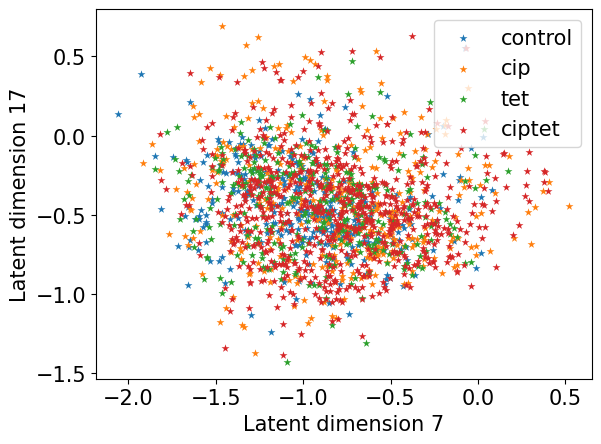

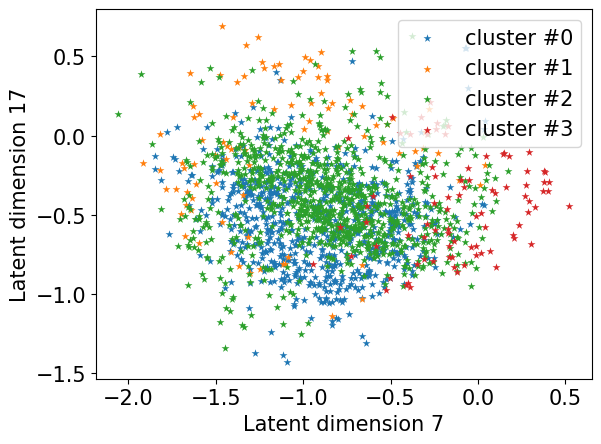

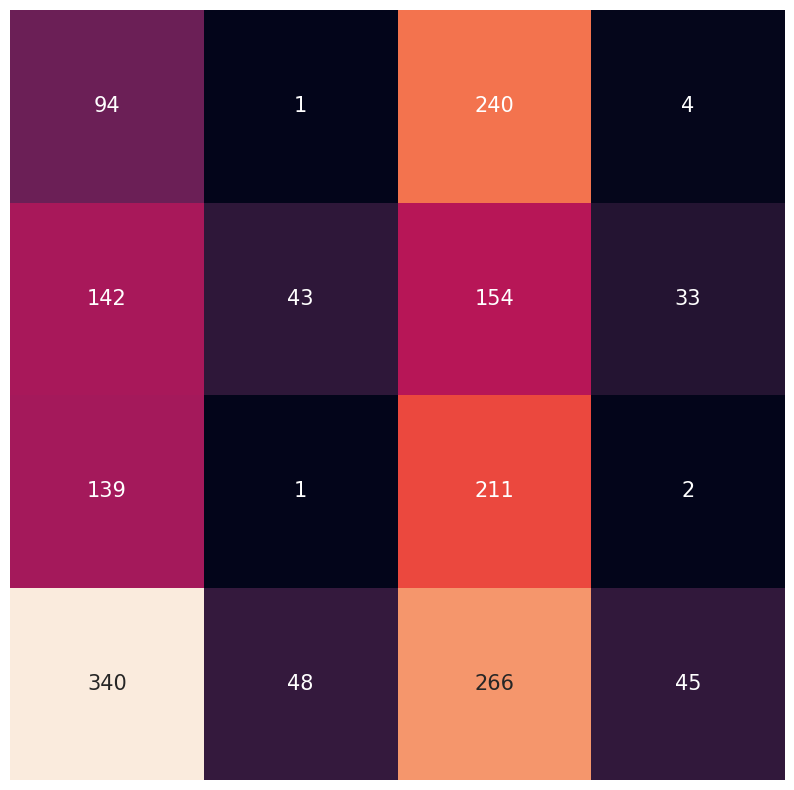

In [98]:
#clustering glucose data 4 clusters
from sklearn.cluster import KMeans, DBSCAN
import sklearn.metrics
import seaborn as sns


projected_glu = projected_comme_jamaid[[k[0] == 'glu' for k in gigadataset_Y],:]

label_map_antibiotics = {'control':0, 'cip':1, 'tet':2, 'ciptet':3}
labels_glu = np.array([label_map_antibiotics[k[1]] for k in gigadataset_Y if k[0] == 'glu'])

km_clustering = KMeans(n_clusters=4, n_init = 100).fit(projected_glu)
# km_clustering = KMeans(n_clusters=4, n_init = 100).fit(z_run_glu_pca[:,:4])

km_labels = km_clustering.labels_


print(np.unique(km_labels, return_counts=True))
print(np.unique(labels_glu, return_counts=True))
print(sklearn.metrics.rand_score(labels_glu, km_labels))
print(sklearn.metrics.adjusted_rand_score(labels_glu, km_labels))

j1=7#np.random.randint(20)
j2=17#np.random.randint(20)

plt.figure()
for i in range(4):
    plt.scatter(projected_glu[labels_glu==i,j1], projected_glu[labels_glu==i,j2], marker='*', linewidths=0, label = ['control', 'cip', 'tet', 'ciptet'][i])
plt.xlabel(f'Latent dimension {j1}')
plt.ylabel(f'Latent dimension {j2}')
plt.legend()

plt.figure()
for i in range(4):
    plt.scatter(projected_glu[km_clustering.labels_==i,j1], projected_glu[km_clustering.labels_==i,j2], marker='*', linewidths=0, label = f'cluster #{i}')
plt.xlabel(f'Latent dimension {j1}')
plt.ylabel(f'Latent dimension {j2}')
plt.legend()

confusion_matrix = sklearn.metrics.confusion_matrix(labels_glu, km_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=False, yticklabels=False, cbar=False)

In [ ]:
### dbscan attempt glu
ep_range = np.linspace(0.6,2, 100) 

track_dict = {"inertia":[], "silhouette":[], "n_cluster":[], "db":[], "noise":[],"RI":[], "ARI":[]}
for i in ep_range:
    db = DBSCAN(eps=i,min_samples=10).fit(projected_glu)
    sil = 0
    if len(np.unique(db.labels_))>2:
        sil = sklearn.metrics.silhouette_score(np.array([projected_glu[i,:] for i in range(len(projected_glu)) if db.labels_[i] != -1]), [i for i in db.labels_ if i != -1])
    track_dict["silhouette"].append(sil)
    track_dict["n_cluster"].append(len(np.unique(db.labels_)))
    track_dict["db"].append(db)
    track_dict["noise"].append(np.sum(db.labels_==-1)*100/len(db.labels_))
    track_dict["RI"].append(sklearn.metrics.rand_score(labels_glu, db.labels_))
    track_dict["ARI"].append(sklearn.metrics.adjusted_rand_score(labels_glu, db.labels_))

# 30s 50 epval

####### plot eprange scan results
fig, ax = plt.subplots(4,1,figsize = (13,11))
ax[0].plot(track_dict["silhouette"], marker = "+", color= "red")
# ax[0].plot(track_dict["noise"], marker = "+", color= "red")
ax[0].xaxis.set_major_locator(plt.NullLocator())
ax[0].set_ylabel("Silhouette Score")
ax[1].plot(ep_range, track_dict["n_cluster"], marker = "+", color= "black")
ax[1].set_ylabel("number of clusters")
ax[1].set_xlabel("epsilon")


ax[2].plot(track_dict["RI"], marker = "+", color= "green")
# ax[0].plot(track_dict["noise"], marker = "+", color= "red")
ax[2].xaxis.set_major_locator(plt.NullLocator())
ax[2].set_ylabel("RI")
ax[3].plot(ep_range, track_dict["ARI"], marker = "+", color= "brown")
ax[3].set_ylabel("ARI")
ax[3].set_xlabel("epsilon")

print(ep_range[np.argmax(track_dict["ARI"])])
print(np.max(track_dict["ARI"])), print(np.max(track_dict["RI"]))

# #### make 1 good dbscan and plot results
DBSCAN_clustering = DBSCAN(eps=0.95, min_samples=4).fit(projected_glu)

plt.figure(figsize=(10, 7))
for i in range(-1,4):
    plt.scatter(projected_glu[DBSCAN_clustering.labels_==i,0], projected_glu[DBSCAN_clustering.labels_==i,19], marker='*', linewidths=0, label = ['cluster#1', 'cluster#2', 'cluster#3','cluster#4','Noise'][i])
plt.legend()
plt.xlabel('Latent dimension 0')
plt.ylabel('Latent dimension 19')
# plt.scatter(projected_comme_jamaid[:,0], projected_comme_jamaid[:,5], c=DBSCAN_clustering.labels_, marker='*', linewidths=0)


confusion_matrix = sklearn.metrics.confusion_matrix(labels_glu, DBSCAN_clustering.labels_)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=False, yticklabels=False, cbar=False)

print(np.unique(DBSCAN_clustering.labels_, return_counts=True))
np.unique(labels_glu, return_counts=True)

In [ ]:
#clustering glycerol data 4 clusters
from sklearn.cluster import KMeans, DBSCAN
import sklearn.metrics


projected_gly = projected_comme_jamaid[[k[0] == 'gly' for k in gigadataset_Y],:]

label_map_antibiotics = {'control':0, 'cip':1, 'tet':2, 'ciptet':3}
labels_gly = np.array([label_map_antibiotics[k[1]] for k in gigadataset_Y if k[0] == 'gly'])

km_clustering = KMeans(n_clusters=4, n_init = 100).fit(projected_gly)
# km_clustering = KMeans(n_clusters=4, n_init = 100).fit(z_run_gly_pca[:,:4])

km_labels = km_clustering.labels_


print(np.unique(km_labels, return_counts=True))
print(np.unique(labels_gly, return_counts=True))
print(sklearn.metrics.rand_score(labels_gly, km_labels))
print(sklearn.metrics.adjusted_rand_score(labels_gly, km_labels))

j1=7#np.random.randint(20)
j2=17#np.random.randint(20)

plt.figure()
for i in range(4):
    plt.scatter(projected_gly[labels_gly==i,j1], projected_gly[labels_gly==i,j2], marker='*', linewidths=0, label = ['control', 'cip', 'tet', 'ciptet'][i])
plt.xlabel(f'Latent dimension {j1}')
plt.ylabel(f'Latent dimension {j2}')
plt.legend()

plt.figure()
for i in range(4):
    plt.scatter(projected_gly[km_clustering.labels_==i,j1], projected_gly[km_clustering.labels_==i,j2], marker='*', linewidths=0, label = f'cluster #{i}')
plt.xlabel(f'Latent dimension {j1}')
plt.ylabel(f'Latent dimension {j2}')
plt.legend()

confusion_matrix = sklearn.metrics.confusion_matrix(labels_gly, km_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=False, yticklabels=False, cbar=False)

In [1]:
#clustering gluaacerol data 4 clusters
from sklearn.cluster import KMeans, DBSCAN
import sklearn.metrics


projected_gluaa = projected_comme_jamaid[[k[0] == 'gluaa' for k in gigadataset_Y],:]

label_map_antibiotics = {'control':0, 'cip':1, 'tet':2, 'ciptet':3}
labels_gluaa = np.array([label_map_antibiotics[k[1]] for k in gigadataset_Y if k[0] == 'gluaa'])

km_clustering = KMeans(n_clusters=4, n_init = 100).fit(projected_gluaa)
# km_clustering = KMeans(n_clusters=4, n_init = 100).fit(z_run_gluaa_pca[:,:4])

km_labels = km_clustering.labels_


print(np.unique(km_labels, return_counts=True))
print(np.unique(labels_gluaa, return_counts=True))
print(sklearn.metrics.rand_score(labels_gluaa, km_labels))
print(sklearn.metrics.adjusted_rand_score(labels_gluaa, km_labels))

j1=7#np.random.randint(20)
j2=17#np.random.randint(20)

plt.figure()
for i in range(4):
    plt.scatter(projected_gluaa[labels_gluaa==i,j1], projected_gluaa[labels_gluaa==i,j2], marker='*', linewidths=0, label = ['control', 'cip', 'tet', 'ciptet'][i])
plt.xlabel(f'Latent dimension {j1}')
plt.ylabel(f'Latent dimension {j2}')
plt.legend()

plt.figure()
for i in range(4):
    plt.scatter(projected_gluaa[km_clustering.labels_==i,j1], projected_gluaa[km_clustering.labels_==i,j2], marker='*', linewidths=0, label = f'cluster #{i}')
plt.xlabel(f'Latent dimension {j1}')
plt.ylabel(f'Latent dimension {j2}')
plt.legend()

confusion_matrix = sklearn.metrics.confusion_matrix(labels_gluaa, km_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=False, yticklabels=False, cbar=False)

NameError: name 'projected_comme_jamaid' is not defined

Accuracy: 0.509915014164306
Precision: 0.5117320940832576
Recall: 0.509915014164306
F1 Score: 0.510431462234499

random classification
Accuracy: 0.21246458923512748
Precision: 0.26977270545303417
Recall: 0.21246458923512748
F1 Score: 0.22090334583561874


<Axes: >

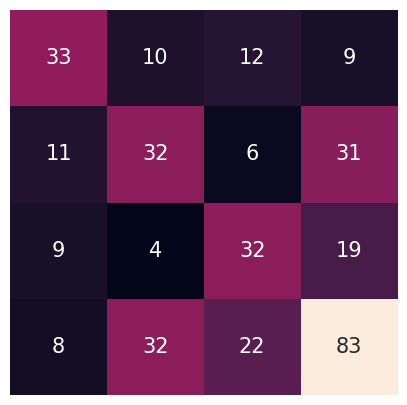

In [100]:
#MLP classfier
from sklearn.cluster import KMeans, DBSCAN
import sklearn.metrics
label_map_antibiotics = {'control':0, 'cip':1, 'tet':2, 'ciptet':3}
projected_gluaa = projected_comme_jamaid[[k[0] == 'gluaa' for k in gigadataset_Y],:]
labels_gluaa = np.array([label_map_antibiotics[k[1]] for k in gigadataset_Y if k[0] == 'gluaa'])

X = projected_glu
y = labels_glu

from sklearn.model_selection import train_test_split

# Assuming X is your data and y are your labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

from sklearn.neural_network import MLPClassifier

# Create a MLP classifier
clf = MLPClassifier(hidden_layer_sizes = np.array([1000]), max_iter=1000, random_state=42) #np.int32(np.ones(1)*1000)

# Train the classifier
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_test is your test labels and X_test is your test data
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

print('\nrandom classification')
random_classifications = np.random.randint(0,4,len(y_test))
print('Accuracy:', accuracy_score(y_test, random_classifications))
print('Precision:', precision_score(y_test, random_classifications, average='weighted'))
print('Recall:', recall_score(y_test, random_classifications, average='weighted'))
print('F1 Score:', f1_score(y_test, random_classifications, average='weighted'))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=False, yticklabels=False, cbar=False)

In [95]:
X = projected_comme_jamaid
y = [label_map[k[:2]] for k in gigadataset_Y]

from sklearn.model_selection import train_test_split

# Assuming X is your data and y are your labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

from sklearn.neural_network import MLPClassifier

# Create a MLP classifier
clf = MLPClassifier(hidden_layer_sizes = np.array([1000,1000,1000]), max_iter=1000, random_state=42) #np.int32(np.ones(1)*1000)

# Train the classifier
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_test is your test labels and X_test is your test data
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

print('\nrandom classification')
random_classifications = np.random.randint(0,4,len(y_test))
print('Accuracy:', accuracy_score(y_test, random_classifications))
print('Precision:', precision_score(y_test, random_classifications, average='weighted'))
print('Recall:', recall_score(y_test, random_classifications, average='weighted'))
print('F1 Score:', f1_score(y_test, random_classifications, average='weighted'))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=False, yticklabels=False, cbar=False)

Accuracy: 0.42776203966005666
Precision: 0.4408740670570596
Recall: 0.42776203966005666
F1 Score: 0.4318480956398592

random classification
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\USERS\ACHFR\.CONDA\ENVS\MLP\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



NameError: name 'sns' is not defined

<Figure size 1000x1000 with 0 Axes>

In [ ]:
z_run_glu == projected_glu

In [ ]:
plt.figure()
for i in range(3):
    plt.scatter(projected_comme_jamaid[label_conditions==i,0], projected_comme_jamaid[label_conditions==i,1], marker='*', linewidths=0, label = i)
plt.legend()

plt.figure()
for i in range(3):
    plt.scatter(projected_comme_jamaid[km_clustering.labels_==i,0], projected_comme_jamaid[km_clustering.labels_==i,1], marker='*', linewidths=0, label = i)
plt.legend()